## Equipe:

- Ademir Guimarães
- Geovani Sampaio
- Gustavo Pacífico
- José Augusto


## Bibliotecas necessárias


In [171]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import random

import tensorflow as tf
from tensorflow.keras import layers, models

## Análise Exploratória


In [172]:
TRAIN_PATH = 'archive/ai_art_classification/train'
AI_GENERATED = f'{TRAIN_PATH}/AI_GENERATED'
NON_AI_GENERATED = f'{TRAIN_PATH}/NON_AI_GENERATED'

In [173]:
def count_images(path):
    return sum(len(files) for _, _, files in os.walk(path))

In [174]:
print(f'Número de imagens: {count_images(TRAIN_PATH)}')
print(f'Número de imagens geradas por IA: {count_images(AI_GENERATED)}')
print(f'Número de imagens não geradas por IA: {
      count_images(NON_AI_GENERATED)}')

Número de imagens: 18618
Número de imagens geradas por IA: 10330
Número de imagens não geradas por IA: 8288


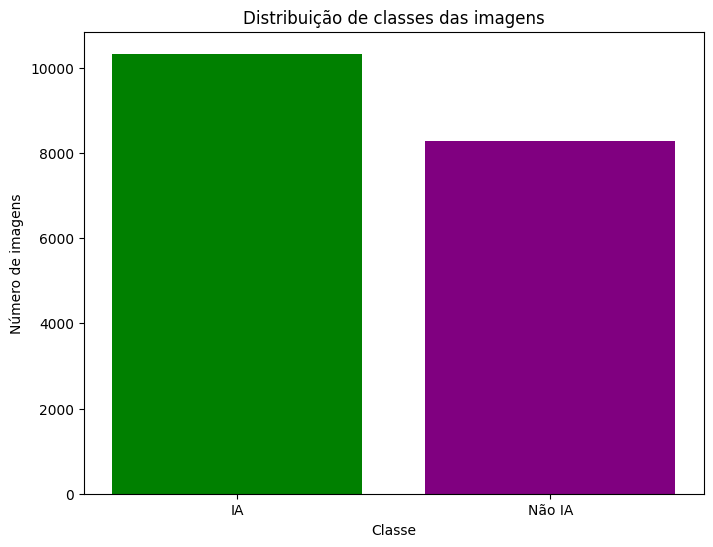

In [175]:
plt.figure(figsize=(8, 6))

labels = ['IA', 'Não IA']
counts = [count_images(AI_GENERATED), count_images(NON_AI_GENERATED)]
plt.bar(labels, counts, color=['green', 'purple'])
plt.title('Distribuição de classes das imagens')
plt.ylabel('Número de imagens')
plt.xlabel('Classe')
plt.show()

In [176]:
def print_image_shapes(path, name):
    shapes_set = set()
    image_names = os.listdir(path)

    if not image_names:
        print(f'O diretório {name} está vazio.')
        return

    for img_name in image_names:
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:
            shapes_set.add(img.shape)

    print(f'Número de dimensões únicas de imagem no conjunto {
          name}: {len(shapes_set)}')
    print(f'Dimensões das imagens no conjunto {name}: {shapes_set}')

In [177]:
print_image_shapes(AI_GENERATED, 'AI')
print_image_shapes(NON_AI_GENERATED, 'NON_AI')

Número de dimensões únicas de imagem no conjunto AI: 1
Dimensões das imagens no conjunto AI: {(512, 512, 3)}
Número de dimensões únicas de imagem no conjunto NON_AI: 1
Dimensões das imagens no conjunto NON_AI: {(512, 512, 3)}


In [178]:
def visualize_images(path, n_images, is_random=True, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.title(path.split('/')[-1])

    w = int(n_images ** .5)
    h = math.ceil(n_images / w)

    all_names = os.listdir(path)
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)

    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    plt.show()

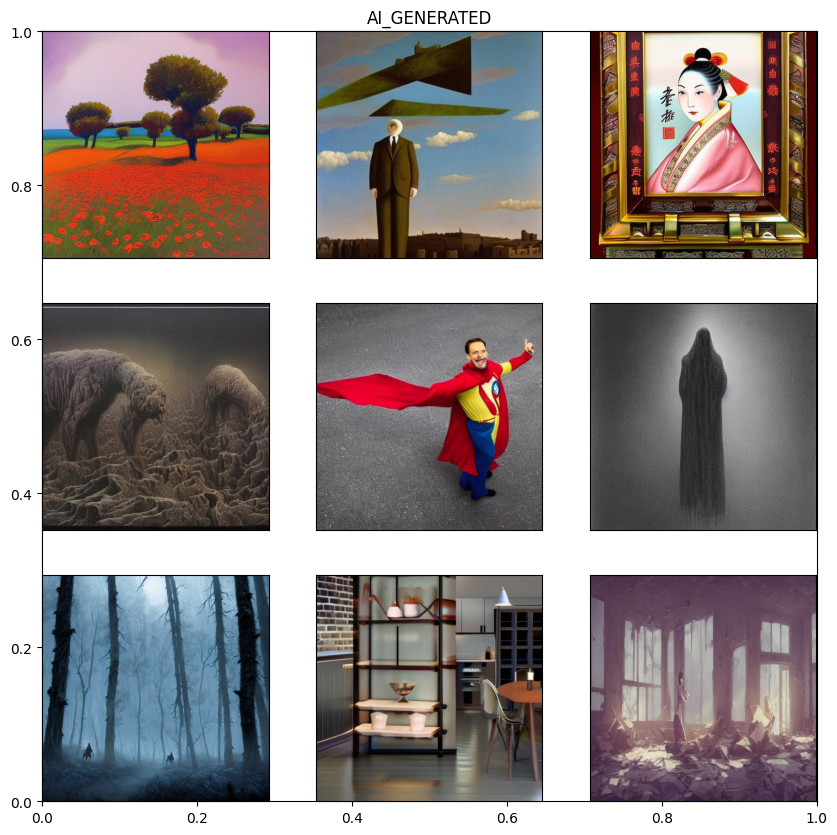

In [179]:
visualize_images(AI_GENERATED, 9)

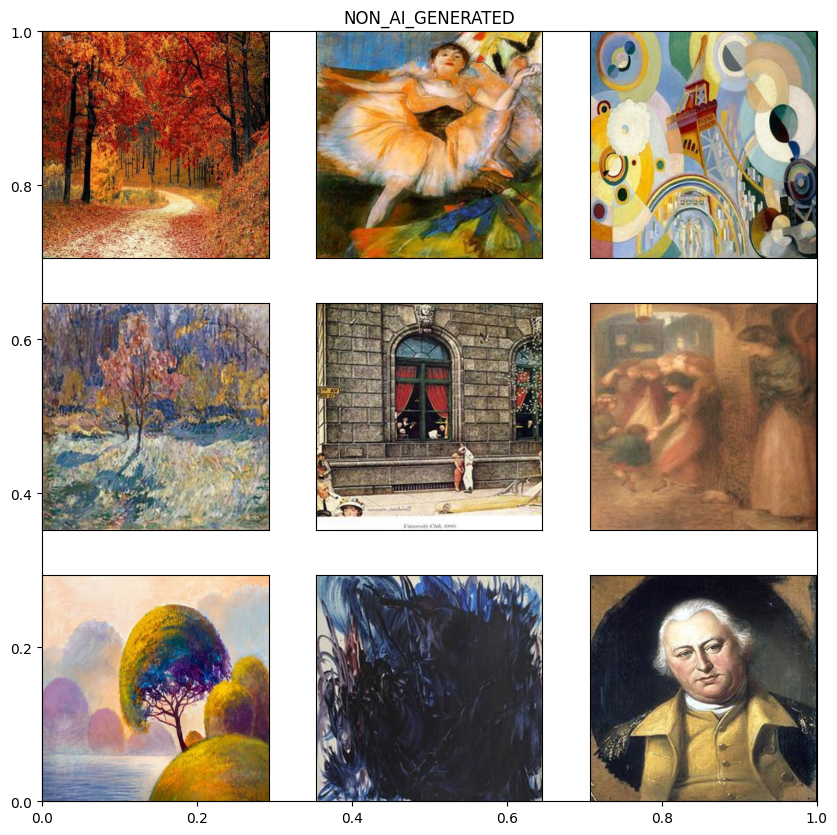

In [180]:
visualize_images(NON_AI_GENERATED, 9)

## Definindo modelo, iterador e hiperparâmetros


In [181]:
BATCH_SIZE = 32
IMG_SIZE = 180

In [185]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 18618 files belonging to 2 classes.
Using 14895 files for training.


In [186]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 18618 files belonging to 2 classes.
Using 3723 files for validation.


In [184]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [187]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [189]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [190]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

In [191]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,769 (15.22 MB)

 Trainable params: 3,988,769 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 89s 159ms/step - accuracy: 0.7518 - loss: 0.4831 - val_accuracy: 0.8775 - val_loss: 0.2776
Epoch 2/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 72s 155ms/step - accuracy: 0.8843 - loss: 0.2594 - val_accuracy: 0.8802 - val_loss: 0.2841
Epoch 3/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 69s 149ms/step - accuracy: 0.9044 - loss: 0.2177 - val_accuracy: 0.8985 - val_loss: 0.2459
Epoch 4/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.9337 - loss: 0.1617 - val_accuracy: 0.8810 - val_loss: 0.2858
Epoch 5/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9485 - loss: 0.1277 - val_accuracy: 0.9022 - val_loss: 0.2577
Epoch 6/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9658 - loss: 0.0917 - val_accuracy: 0.9001 - val_loss: 0.2836
Epoch 7/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - accuracy: 0.9776 - loss: 0.0634 - val_accuracy: 0.9006 - val_loss: 0.3165
Epoch 8/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9859 - loss: 0

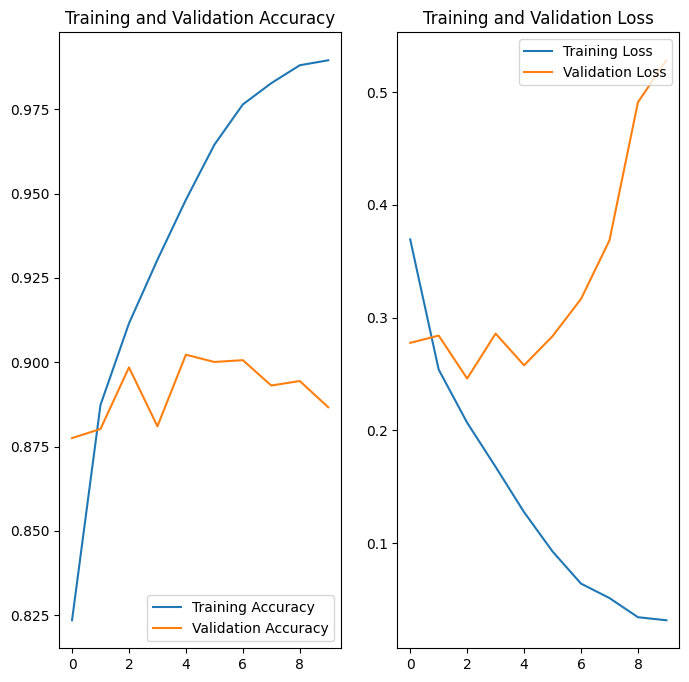

In [193]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Aplicando aumento de dados

In [199]:
data_augmentation = tf.keras.Sequential(
[
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
])